In [2]:
!nvidia-smi


Mon May 12 15:25:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        Off |   00000000:01:00.0  On |                  N/A |
|  0%   54C    P3             29W /  200W |    2348MiB /  12282MiB |     40%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pandas as pd

df = pd.read_csv("cleaned_forms.csv", encoding="utf-8")
df.head()


,Атооч,Илик,Барыш,Табыш,Жатыш,Чыгыш
0,бир,бирдин,бирге,бирди,бирде,бирден
1,манас,манастын,манаска,манасты,манаста,манастан
2,аалам,ааламдын,ааламга,ааламды,ааламда,ааламдан
3,ааламдашуу,ааламдашуунун,ааламдашууга,ааламдашууну,ааламдашууда,ааламдашуудан
4,аалым,аалымдын,аалымга,аалымды,аалымда,аалымдан


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
from sklearn.model_selection import train_test_split

# === Параметры ===
EMBED_DIM = 64
LSTM_UNITS = 128
BATCH_SIZE = 64
EPOCHS = 40

# === Загрузка данных ===
df = pd.read_csv("cleaned_forms.csv").dropna().astype(str)

inputs = df["Атооч"].tolist()
outputs = {
    "gen": df["Илик"].tolist(),
    "dat": df["Барыш"].tolist(),
    "acc": df["Табыш"].tolist(),
    "loc": df["Жатыш"].tolist(),
    "abl": df["Чыгыш"].tolist()
}

# === Алфавит ===
char_set = set()
for word in inputs:
    char_set.update(word)
for forms in outputs.values():
    for word in forms:
        char_set.update(word)

char_list = ["<PAD>", "<EOS>"] + sorted(char_set)
char2idx = {ch: i for i, ch in enumerate(char_list)}
idx2char = {i: ch for ch, i in char2idx.items()}
vocab_size = len(char2idx)
EOS = char2idx["<EOS>"]
PAD = char2idx["<PAD>"]

# === Кодирование ===
def encode(word, maxlen):
    seq = [char2idx.get(ch, 0) for ch in word] + [EOS]
    return seq + [PAD] * (maxlen - len(seq))

max_len_input = max(len(w) for w in inputs) + 1
max_len_output = max(len(w) for v in outputs.values() for w in v) + 1

X = np.array([encode(w, max_len_input) for w in inputs])
Y = {k: np.array([encode(w, max_len_output) for w in v]) for k, v in outputs.items()}
Y = {k: np.expand_dims(v, -1) for k, v in Y.items()}

# === Разделение ===
X_train, X_val, idx_train, idx_val = train_test_split(X, np.arange(len(X)), test_size=0.1, random_state=42)
Y_train = {k: Y[k][idx_train] for k in Y}
Y_val = {k: Y[k][idx_val] for k in Y}

# === Модель ===
inp = tf.keras.Input(shape=(max_len_input,))
x = tf.keras.layers.Embedding(vocab_size, EMBED_DIM, mask_zero=True)(inp)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS))(x)

outs = {}
for case in ["gen", "dat", "acc", "loc", "abl"]:
    r = tf.keras.layers.RepeatVector(max_len_output)(x)
    d = tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True)(r)
    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'), name=case)(d)
    outs[case] = out

model = tf.keras.Model(inputs=inp, outputs=list(outs.values()))
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"] * len(outs)
)
model.summary()

# === Обучение ===
history = model.fit(
    X_train,
    [Y_train[k] for k in outs],
    validation_data=(X_val, [Y_val[k] for k in outs]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2
)

# === Сохранение ===
model.save("atooch_to_cases_model.keras")
with open("atooch_char2idx.json", "w", encoding="utf-8") as f:
    json.dump(char2idx, f, ensure_ascii=False)


2025-05-12 15:26:53.788664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 15:26:53.789050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 15:26:53.790968: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 15:26:53.796182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747042013.805485   16930 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747042013.80

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 64)    │      2,496 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    197,632 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 23, 256)   │          0 │ bidirectional[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 23, 256)   │          0 │ bidirectional[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 23, 256)   │          0 │ bidirectional[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 23, 256)   │          0 │ bidirectional[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 23, 256)   │          0 │ bidirectional[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 23, 128)   │    197,120 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 23, 128)   │    197,120 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 23, 128)   │    197,120 │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 23, 128)   │    197,120 │ repeat_vector_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 23, 128)   │    197,120 │ repeat_vector_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gen                 │ (None, 23, 39)    │      5,031 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dat                 │ (None, 23, 39)    │      5,031 │ lstm_2[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ acc                 │ (None, 23, 39)    │      5,031 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loc                 │ (None, 23, 39)    │      5,031 │ lstm_4[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,210,883 (4.62 MB)

 Trainable params: 1,210,883 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


2025-05-12 15:27:01.553848: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


86/86 - 10s - 121ms/step - abl_accuracy: 0.5706 - abl_loss: 1.7294 - acc_accuracy: 0.5984 - acc_loss: 1.6502 - dat_accuracy: 0.6062 - dat_loss: 1.6358 - gen_accuracy: 0.5647 - gen_loss: 1.7555 - loc_accuracy: 0.6036 - loc_loss: 1.6527 - loss: 8.4500 - val_abl_accuracy: 0.6178 - val_abl_loss: 1.2741 - val_acc_accuracy: 0.6249 - val_acc_loss: 1.2328 - val_dat_accuracy: 0.6290 - val_dat_loss: 1.2119 - val_gen_accuracy: 0.6332 - val_gen_loss: 1.2931 - val_loc_accuracy: 0.6289 - val_loc_loss: 1.2146 - val_loss: 6.2362
Epoch 2/40
86/86 - 3s - 35ms/step - abl_accuracy: 0.6619 - abl_loss: 1.1786 - acc_accuracy: 0.6736 - acc_loss: 1.1342 - dat_accuracy: 0.6770 - dat_loss: 1.1236 - gen_accuracy: 0.6628 - gen_loss: 1.1915 - loc_accuracy: 0.6728 - loc_loss: 1.1340 - loss: 5.7658 - val_abl_accuracy: 0.7014 - val_abl_loss: 1.1217 - val_acc_accuracy: 0.6892 - val_acc_loss: 1.0851 - val_dat_accuracy: 0.7063 - val_dat_loss: 1.0768 - val_gen_accuracy: 0.6800 - val_gen_loss: 1.1355 - val_loc_accuracy: 0.

In [6]:
# === Сохранение истории обучения ===
import json
with open("training_logs.json", "w") as f:
    json.dump(history.history, f)

print("✅ Логи обучения сохранены.")


✅ Логи обучения сохранены.


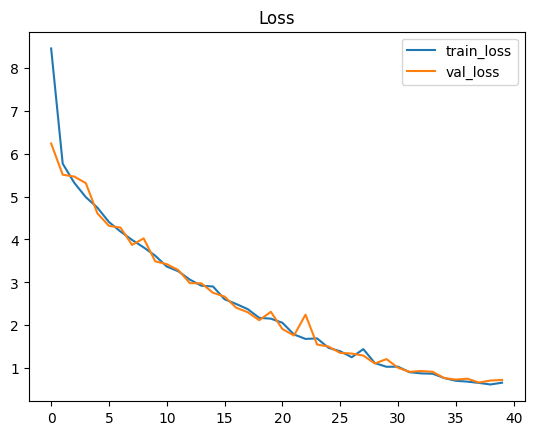

In [8]:
import matplotlib.pyplot as plt
with open("training_logs.json") as f:
    logs = json.load(f)

plt.plot(logs["loss"], label="train_loss")
plt.plot(logs["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()
plt.show()


/tmp/ipykernel_16930/3770119053.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/nurtilek/anaconda3/envs/py31/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


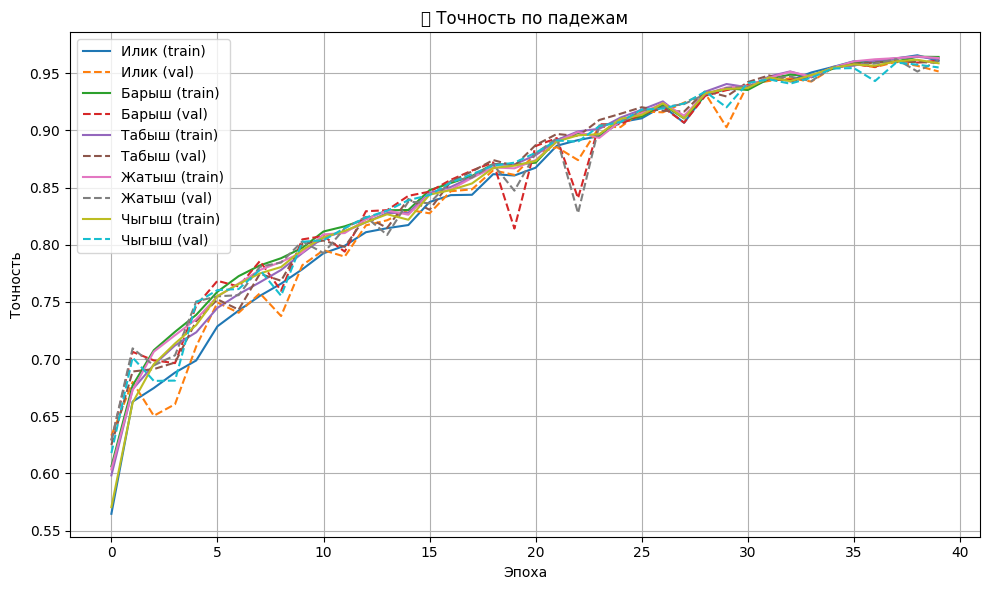

In [9]:
import matplotlib.pyplot as plt
import json

# === Загрузка логов ===
with open("training_logs.json", encoding="utf-8") as f:
    logs = json.load(f)

# === Названия падежей и ключи из логов
cases = {
    "gen": "Илик",
    "dat": "Барыш",
    "acc": "Табыш",
    "loc": "Жатыш",
    "abl": "Чыгыш"
}

# === Построение графиков точности
plt.figure(figsize=(10, 6))
for k, label in cases.items():
    plt.plot(logs[f"{k}_accuracy"], label=f"{label} (train)")
    plt.plot(logs[f"val_{k}_accuracy"], '--', label=f"{label} (val)")

plt.title("📈 Точность по падежам")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# ✅ Google Colab блок для инференса модели (Атооч → 5 падежей)

import numpy as np
import tensorflow as tf
import json

# === Загрузка модели и словаря ===
model = tf.keras.models.load_model("atooch_to_cases_model.keras")
with open("atooch_char2idx.json", "r", encoding="utf-8") as f:
    char2idx = json.load(f)
idx2char = {i: ch for ch, i in char2idx.items()}
EOS = char2idx["<EOS>"]
PAD = char2idx["<PAD>"]

max_len_input = model.input_shape[1]
max_len_output = model.output_shape[0][1]

# === Вспомогательные функции ===
def encode(word):
    seq = [char2idx.get(ch, PAD) for ch in word] + [EOS]
    return np.array([seq + [PAD]*(max_len_input - len(seq))])

def decode(indices):
    return ''.join(idx2char.get(int(i), '') for i in indices if int(i) not in [EOS, PAD])

# === Интерактивный инференс ===
print("\n🔤 Введите слово в падеже Атооч:")
while True:
    word = input("Атооч (или 'exit'): ").strip()
    if word.lower() == "exit":
        break
    if not word:
        continue
    x = encode(word)
    preds = model.predict(x, verbose=0)
    cases = ["Илик", "Барыш", "Табыш", "Жатыш", "Чыгыш"]
    print(f"\nСлово: {word}")
    for i, p in enumerate(preds):
        pred_seq = np.argmax(p[0], axis=-1)
        print(f"{cases[i]}: {decode(pred_seq)}")
    print("\n---\n")



🔤 Введите слово в падеже Атооч:

Слово: алма
Илик: алманын
Барыш: алмага
Табыш: алманы
Жатыш: алмада
Чыгыш: алмадан

---



In [1]:
import os
os.getcwd()
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


2025-05-04 23:12:14.438973: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 23:12:14.520184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-04 23:12:14.520250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-04 23:12:14.523105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 23:12:14.536478: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 23:12:14.537669: I tensorflow/core/platform/cpu_feature_guard.cc:1

TensorFlow version: 2.15.0
